# XYG3 型泛函电场梯度 CheatSheet

我们曾经在最初的时候，提及 RHF 方法下的电场梯度 (从而得到偶极矩)；但由于电场梯度会产生众多零值 Skeleton 导数，因此不适合用于对更为广泛的梯度性质进行讨论。于是，我们后来的文档都使用核坐标梯度来说明问题。现在我们再回到电场梯度；我们尝试求取 XYG3 型泛函的偶极矩。

## 准备工作

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib
from pyscf.scf import cphf
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import DipoleDerivGenerator, NumericDiff, GridHelper, KernelHelper
from pyxdh.DerivOnce import DipoleSCF, DipoleMP2, DipoleXDH

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
def mol_to_grids(mol, atom_grid=(75, 302)):
    grids = dft.Grids(mol)
    grids.atom_grid = atom_grid
    grids.becke_scheme = dft.gen_grid.stratmann
    grids.prune = None
    grids.build()
    return grids
grids = mol_to_grids(mol)

In [4]:
def mol_to_scf(mol):
    scf_eng = dft.RKS(mol)
    scf_eng.grids = mol_to_grids(mol)
    scf_eng.xc = "B3LYPg"
    scf_eng.conv_tol = 1e-10
    return scf_eng.run()

In [5]:
def mol_to_nc(mol):
    nc_eng = dft.RKS(mol)
    nc_eng.grids = mol_to_grids(mol)
    nc_eng.xc = "0.8033*HF - 0.0140*LDA + 0.2107*B88, 0.6789*LYP"
    nc_eng.conv_tol = 1e-10
    return nc_eng

In [6]:
scf_eng = mol_to_scf(mol)
nc_eng = mol_to_nc(mol)
diph = DipoleXDH({"scf_eng": scf_eng, "nc_eng": nc_eng, "cc": 0.3211, "cphf_tol": 1e-12})

In [7]:
nmo, nao, natm, nocc, nvir, cx, cc, cx_n = diph.nao, diph.nao, diph.natm, diph.nocc, diph.nvir, diph.cx, diph.cc, diph.nc_deriv.cx
mol_slice = diph.mol_slice
so, sv, sa = diph.so, diph.sv, diph.sa
C, Co, Cv, e, eo, ev, D = diph.C, diph.Co, diph.Cv, diph.e, diph.eo, diph.ev, diph.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = diph.H_0_ao, diph.S_0_ao, diph.eri0_ao, diph.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = diph.H_0_mo, diph.S_0_mo, diph.eri0_mo, diph.F_0_mo
T_iajb, t_iajb, D_iajb = diph.T_iajb, diph.t_iajb, diph.D_iajb

In [8]:
grdh = GridHelper(mol, grids, D)
ao_0, ao_1, ao_2 = grdh.ao_0, grdh.ao_1, grdh.ao_2
rho_0, rho_1, rho_2 = grdh.rho_0, grdh.rho_1, grdh.rho_2

In [9]:
kerh = KernelHelper(grdh, "B3LYPg")
kerh_n = KernelHelper(grdh, "0.8033*HF - 0.0140*LDA + 0.2107*B88, 0.6789*LYP")

In [10]:
def dipole_generator(component, interval):
    def get_hcore(mol=mol):
        return scf.rhf.get_hcore(mol) - interval * mol.intor("int1e_r")[component]
    mf_scf = mol_to_scf(mol)
    mf_nc = mol_to_nc(mol)
    mf_scf.get_hcore = get_hcore
    mf_nc.get_hcore = get_hcore
    mf_scf.run()
    return DipoleXDH({"scf_eng": mf_scf, "nc_eng": mf_nc, "cc": 0.3211, "cphf_tol": 1e-12})

dipn = DipoleDerivGenerator(dipole_generator)

In [11]:
def plot_diff(anal_mat, num_mat):
    fig, ax = plt.subplots(figsize=(2.4, 1.8)); ax.set_xscale("log")
    ax.hist(abs(anal_mat.ravel() - num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    ax.hist(abs(num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    return fig.tight_layout()

## XYG3 型电场梯度：程序实现 CheatSheet

XYG3 type of double hybrid functional derivative：

$$
\begin{align}
\partial_\mathbb{A} E_\mathrm{tot}
&= h_{\mu \nu}^\mathbb{A} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda)^\mathbb{A} D_{\kappa \lambda} - \frac{c_\mathrm{x}^\mathrm{n}}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda)^\mathbb{A} D_{\kappa \lambda} + f_\rho^\mathrm{n} \rho^\mathbb{A} + f_\gamma^\mathrm{n} \gamma^\mathbb{A} - 2 S_{ij}^\mathbb{A} F_{ij}^\mathrm{n} \\
&\quad + D_{pq}^\mathrm{PT2+} B_{pq}^\mathbb{A} + W_{pq}^\mathrm{PT2} [\mathrm{I}] S_{pq}^\mathbb{A} + 2 T_{ij}^{ab} (ia|jb)^\mathbb{A} + \partial_\mathbb{A} E_\mathrm{nuc}
\end{align}
$$

### Derivative Unrelated Tensors

For all derivative-unrelated tensors, we refer to the realization from previous xDH nucleus coordinate derivative [cheatsheet](grad_xdh.ipynb#XYG3-型核坐标梯度：程序实现-CheatSheet).

- `nc_F_0_ao` $F_{\mu \nu}^\mathrm{n}$

- `Ax0_Core` $A_{pq, rs}$

- PT2 Tensors

- `W_I` $W_{pq}^\mathrm{PT2} [\mathrm{I}]$

- `D_r` $D_{pq}^\mathrm{PT2+}$

- `L` $L_{ai}^\mathrm{PT2+}$ PT2+

In [12]:
nc_F_0_ao, nc_F_0_mo = diph.nc_deriv.F_0_ao, diph.nc_deriv.F_0_mo
Ax0_Core = diph.Ax0_Core
T_iajb, t_iajb, D_iajb = diph.T_iajb, diph.t_iajb, diph.D_iajb
W_I, D_r, L = diph.W_I, diph.D_r, diph.L

### Zero Derivative Tensors

- `S_1_ao` $S_{\mu \nu}^t$

- `eri1_ao` $(\mu \nu | \kappa \lambda)^t$

- $\rho^t$, $\rho_r^t$, $\gamma^t$

### `H_1_ao` $h_{\mu \nu}^t$ Hamiltonian Core Skeleton

- `H_1_ao` $h_{\mu \nu}^{t}$; dim: $(t, \mu, \nu)$; symm: $h_{\mu \nu}^{t} = h_{\nu \mu}^{t}$

$$
h_{\mu \nu}^{t} = - \langle \mu | t | \nu \rangle
$$

Note that $t$ in $\langle \mu | t | \nu \rangle$ means electron coordinate component, not kinetic operator $\hat t$.

In [13]:
H_1_ao = - mol.intor("int1e_r")
H_1_ao.shape

(3, 22, 22)

In [14]:
np.allclose(H_1_ao, H_1_ao.swapaxes(-1, -2))  # symm check

True

In [15]:
np.allclose(H_1_ao, diph.H_1_ao)  # pyxdh approach

True

<IPython.core.display.Javascript object>


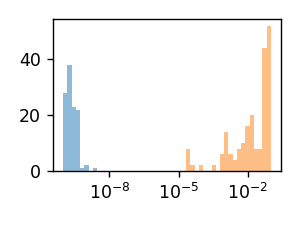

In [16]:
nd_H_0_ao = NumericDiff(dipn, lambda diph: diph.H_0_ao).derivative
plot_diff(H_1_ao, nd_H_0_ao)

- `H_1_mo` $h_{pq}^{t}$; dim: $(t, p, q)$; symm: $h_{pq}^{t} = h_{qp}^{t}$

$$
h_{pq}^{t} = C_{\mu p} h_{\mu \nu}^{t} C_{\nu q}
$$

In [17]:
H_1_mo = np.einsum("up, tuv, vq -> tpq", C, H_1_ao, C)
H_1_mo.shape

(3, 22, 22)

In [18]:
np.allclose(H_1_mo, diph.H_1_mo)  # pyxdh approach

True

### `F_1_ao` $F_{\mu \nu}^{t}$ (Self-consistent) Fock Skeleton

- `F_1_ao` $F_{\mu \nu}^{t} = h_{\mu \nu}^{t}$

- `F_1_mo` $F_{pq}^{t} = h_{pq}^{t}$

In [19]:
F_1_ao, F_1_mo = H_1_ao, H_1_mo

In [20]:
np.allclose(F_1_ao, diph.F_1_ao)  # pyxdh approach

True

In [21]:
np.allclose(F_1_mo, diph.F_1_mo)  # pyxdh approach

True

### `B_1` $B_{pq}^{t}$ B Matrix (CP-HF Equation RHS)

- `B_1` $B_{pq}^{t} = F_{pq}^t$

In [22]:
B_1 = F_1_mo

In [23]:
np.allclose(B_1, diph.B_1)  # pyxdh approach

True

### `U_1_vo` $U_{ai}^{t}$ U Matrix Virt-Occ Block (Unnecessary for xDH Gradient)

- `U_1_vo` $U_{ai}^{t}$; dim: $(t, p, q)$

$$
- (\varepsilon_a - \varepsilon_i) U_{ai}^{t} - A_{ai, bj} U_{bj}^{t} = B_{ai}^{t}
$$

In [24]:
U_1_vo = cphf.solve(
    Ax0_Core(sv, so, sv, so),
    e,
    diph.mo_occ,
    B_1[:, sv, so],
    tol=1e-12,
)[0]
U_1_vo.shape

(3, 13, 9)

In [25]:
np.allclose(
    B_1[:, sv, so] + (ev[:, None] - eo[None, :]) * U_1_vo + Ax0_Core(sv, so, sv, so)(U_1_vo),
    np.zeros((3, nvir, nocc))
)  # check sanity by CP-HF equation

True

<IPython.core.display.Javascript object>


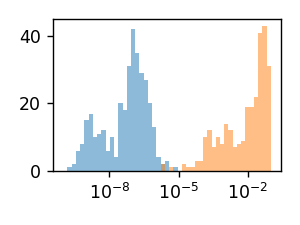

In [26]:
nd_C = NumericDiff(dipn, lambda diph: diph.C).derivative
nd_U_1_vo = np.einsum("mu, tup -> tmp", np.linalg.inv(C), nd_C)[:, sv, so]
plot_diff(U_1_vo, nd_U_1_vo)

### `E_1_nuc` $\partial_{F_t} E_\mathrm{nuc}$ Nucleus Repulsion Energy Derivative

- `E_1_nuc` $\partial_{F_t} E_\mathrm{nuc}$; dim: $(t, )$

$$
\partial_{F_t} E_\mathrm{nuc} = Z_A A_t
$$

In [27]:
E_1_nuc = np.einsum("A, At -> t", mol.atom_charges(), mol.atom_coords())
E_1_nuc

array([ 1.88973,  1.32281, 24.56644])

### `E_1_elec` $\partial E_\mathrm{elec}$ XYG3 Electronic Energy Derivative

- `E_1_elec` $\partial_{F_t} E_\mathrm{elec}$; dim: $(t, )$

$$
\begin{align}
\partial_{F_t} E_\mathrm{elec}
&= h_{\mu \nu}^{t} D_{\mu \nu} + D_{pq}^\mathrm{PT2+} B_{pq}^{t}
\end{align}
$$

In [28]:
E_1_elec = (
    + np.einsum("tuv, uv -> t", H_1_ao, D)
    + np.einsum("pq, tpq -> t", D_r, B_1)
)
E_1_elec

array([ -1.0425 ,  -0.70621, -24.90992])

We can use numerical derivative to verify $\partial_{A_t} E_\mathrm{elec}$; however, numerical derivative of total energy $E_\mathrm{tot}$ only returns $\partial_{A_t} E_\mathrm{elec}$ but not $\partial_{A_t} E_\mathrm{tot}$. Nucleus contribution is simply left-out.

In [29]:
nd_E_0 = NumericDiff(dipn, lambda diph: diph.eng).derivative
nd_E_0

array([ -1.0425 ,  -0.70621, -24.90992])

In [30]:
np.allclose(E_1_elec, nd_E_0)

True

Although $h_{pq}^{t} = B_{pq}^{t}$, it does not mean $\partial_{F_s} h_{pq}^{t} = \partial_{F_s} B_{pq}^{t}$. So, we do not write $\partial_{F_t} E_\mathrm{elec}$ as $h_{pq}^{t} (D_{pq} + D_{pq}^\mathrm{PT2+})$.

### `E_1` $\partial E_\mathrm{tot}$ XYG3 Total Energy Derivative

- `E_1` $\partial_{F_t} E_\mathrm{tot}$; dim: $(t, )$

$$
\partial_{F_t} E_\mathrm{tot} = \partial_{F_t} E_\mathrm{elec} + \partial_{F_t} E_\mathrm{nuc}
$$

In [31]:
E_1 = E_1_elec + E_1_nuc
E_1

array([ 0.84722,  0.6166 , -0.34348])